# import libraries

In [6]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

import torch
import torch.nn as nn
from torchvision.models import resnet50, ResNet50_Weights, resnet18, ResNet18_Weights
from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights
from torchvision.transforms import InterpolationMode
from torchvision import datasets, transforms
from torch.utils.data import Dataset,DataLoader, random_split

import os
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import joblib
from datetime import datetime

In [2]:
home_folder="."

# load trained model

In [3]:
models_folder=home_folder+'/outputs/models'
weights_path = models_folder + "/model_resnet18_val077_2025-03-25_21-22-58.pth"  # Replace with the actual file name
checkpoint = torch.load(weights_path)  # Load on CPU or specify device
sex_detection = resnet18(weights=None)
in_features = sex_detection.fc.in_features
sex_detection.fc = nn.Linear(in_features, 2)
sex_detection.load_state_dict(checkpoint['model_state_dict'])
print(checkpoint['training_metadata'])

{'model_name': 'resnet18', 'epochs': 10, 'batch_size': 16, 'learning_rate': 0.001, 'optimizer': 'Adam', 'loss_function': 'CrossEntropyLoss', 'train_accuracy': 0.996, 'val_accuracy': 0.7657, 'type': 'progressive_unfreezing', 'use_patches': True}


In [6]:
resnet18_model = resnet18(weights=ResNet18_Weights.DEFAULT)


In [10]:
print(sex_detection)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# load examples to analyze

## handwriting

In [4]:
# Define the file path
file_path = home_folder+"\\Data\\train_df_expanded.csv" #cause the . directory is the notebooks folder

train_df_expanded = pd.read_csv(file_path)
print(train_df_expanded.head())

   writer  same_text  isEng  train  \
0       1          0      0      1   
1       1          0      0      1   
2       1          0      0      1   
3       1          0      0      1   
4       1          0      0      1   

                                           file_name  male     x    y    x2  \
0  D:\download\PD project\datasets\ICDAR 2013 - G...     0     0  493   493   
1  D:\download\PD project\datasets\ICDAR 2013 - G...     0   493  493   986   
2  D:\download\PD project\datasets\ICDAR 2013 - G...     0   986  493  1479   
3  D:\download\PD project\datasets\ICDAR 2013 - G...     0  1479  493  1972   
4  D:\download\PD project\datasets\ICDAR 2013 - G...     0  1972  493  2465   

    y2  n_cc  
0  986   111  
1  986    96  
2  986    90  
3  986    99  
4  986    99  


In [5]:
#i select the m patches per writer that have the highest number of cc
m=10
train_df_expanded_sorted = train_df_expanded.sort_values(by='n_cc', ascending=False)
train_df_expanded = train_df_expanded_sorted.groupby('writer').head(m)

In [7]:
class CustomPatchDataset(Dataset):
    def __init__(self, df, label_column,transform=None):
        """
        Args:
            image_dirs (list of str): List of directories to load images from.
            labels_df (DataFrame): DataFrame containing labeled images.
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.image_files = df['file_name'].tolist()
        self.img_labels = df[label_column].tolist()
        self.img_writers = df['writer'].tolist()
        self.x1 = df['x'].tolist()
        self.y1 = df['y'].tolist()
        self.x2 = df['x2'].tolist()
        self.y2 = df['y2'].tolist()
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        x1=self.x1[idx]
        y1=self.y1[idx]
        x2=self.x2[idx]
        y2=self.y2[idx]
        image = Image.open(img_path).convert("RGB")
        patch = image.crop((x1, y1, x2, y2))
        writer=self.img_writers[idx]
        label = self.img_labels[idx]

        if self.transform:
            patch = self.transform(patch)

        return {
            'image': patch,
            'writer': int(writer),
            'label': label
        }

In [8]:
transform_resnet18 = transforms.Compose([
        transforms.Resize(256,interpolation=InterpolationMode.BILINEAR),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        #transforms.Pad((0, 0, 0, 0), fill=0, padding_mode="constant"),  # Optional: Add padding if needed
        #weights["efficient"].transforms()
    ])

In [9]:
N_max = 282
train_dataset = CustomPatchDataset(train_df_expanded[(train_df_expanded['train']==1) & (train_df_expanded['writer']<=N_max)] ,
                                    label_column='male', transform=transform_resnet18)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

val_dataset = CustomPatchDataset(train_df_expanded[(train_df_expanded['train']==0) & (train_df_expanded['writer']<=N_max)] ,
                                label_column='male', transform=transform_resnet18)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True)

## imagenet

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.2885156].


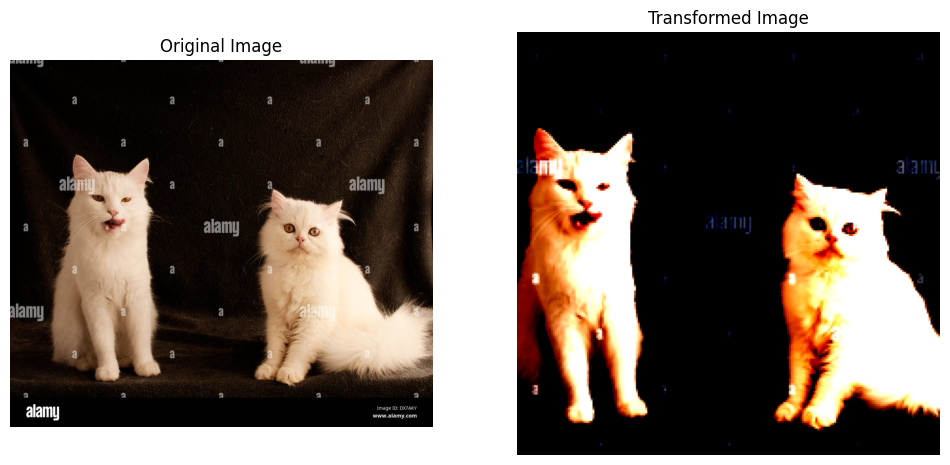

In [46]:
# Load the image
#img = Image.open("Tortoise.jpg").convert("RGB")
#img = Image.open("4-terrapins.jpg").convert("RGB")
img = Image.open("two_cats.jpg").convert("RGB")
#img = Image.open("example_text_0035_4.jpg").convert("RGB")
# Apply it to the input image
preprocess = ResNet18_Weights.DEFAULT.transforms()
img_transformed = preprocess(img)
# Plot the original and transformed images side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Original image
axes[0].imshow(img)
axes[0].set_title("Original Image")
axes[0].axis('off')

# Transformed image
transformed_img = img_transformed.permute(1, 2, 0)  # Change the order of dimensions to (H, W, C)
axes[1].imshow(transformed_img)
axes[1].set_title("Transformed Image")
axes[1].axis('off')

plt.show()

In [47]:
resnet18_model.eval()
batch = img_transformed.unsqueeze(0)
# Step 4: Use the model and print the predicted category
prediction = resnet18_model(batch).squeeze(0).softmax(0)
class_id = prediction.argmax().item()
print(f"Predicted class ID: {class_id}")
score = prediction[class_id].item()
category_name = ResNet18_Weights.DEFAULT.meta["categories"][class_id]
print(f"{category_name}: {100 * score:.1f}%")
# Get the top 5 predictions
top5_prob, top5_catid = torch.topk(prediction, 5)

# Print the top 5 categories and their scores
for i in range(top5_prob.size(0)):
    category_name = ResNet18_Weights.DEFAULT.meta["categories"][top5_catid[i]]
    score = top5_prob[i].item()
    print(f"{category_name}: {100 * score:.1f}%")

Predicted class ID: 283
Persian cat: 94.7%
Persian cat: 94.7%
lynx: 3.4%
Siamese cat: 0.5%
Egyptian cat: 0.2%
bucket: 0.2%


In [11]:
print(resnet18_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [12]:
print(resnet18_model.layer4[-1])

BasicBlock(
  (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [ ]:
category_test = ResNet18_Weights.DEFAULT.meta["categories"][281]
print(category_test)

tabby


In [48]:
# Convert the tensor to a NumPy array
rgb_image = torch.clamp(transformed_img, 0, 1).numpy().astype(np.float32)

# compute saliency map

## imagenet

### gradcam

In [49]:
target_layers = [resnet18_model.layer4[-1]] #usually last conv layer
input_tensor = img_transformed.unsqueeze(0) #so that the dimension is 1,3,224,224 instead of 3,224,224
# Note: input_tensor can be a batch tensor with several images!

# We have to specify the target we want to generate the CAM for.
targets = [ClassifierOutputTarget(283)] #why we may want to use multiple targets

# Construct the CAM object once, and then re-use it on many images.
with GradCAM(model=resnet18_model, target_layers=target_layers) as cam:
  # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
  grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
  # In this example grayscale_cam has only one image in the batch:
  grayscale_cam = grayscale_cam[0, :]
  visualization = show_cam_on_image(rgb_image, grayscale_cam, use_rgb=True)
  # You can also get the model outputs without having to redo inference
  model_outputs = cam.outputs
  

In [50]:
print(visualization.shape)

(224, 224, 3)


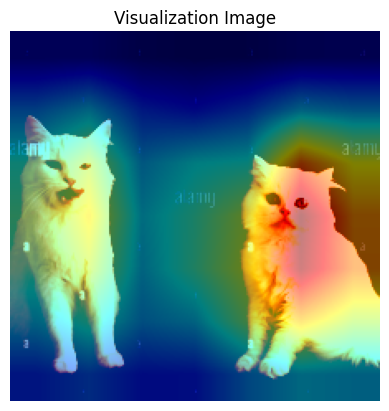

In [51]:
plt.imshow(visualization)
plt.axis('off')  # Turn off the axis
plt.title("Visualization Image")
plt.show()

## handwriting

### gradcam

In [11]:
# Function to show a single image
def show_single_image(image, writer, label, save_path=None):
    img = image.permute(1, 2, 0)  # Change the order of dimensions to (H, W, C)
    plt.imshow(img)
    plt.title(f'Writer: {writer}, Label: {label}')
    plt.axis('off')
    if save_path:
        plt.savefig(save_path)
    plt.show()

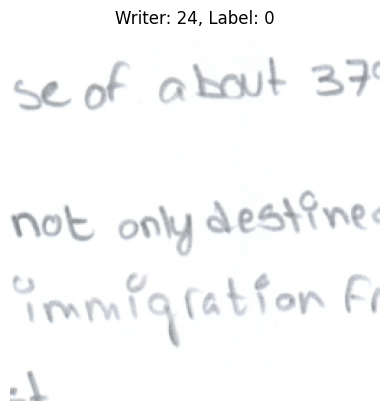

In [15]:
# Specify the index of the image you want to show
index = 42  # Change this to the index of the image you want to display

# Extract the image, writer, and label from the dataset
sample = train_dataset[index]
image = sample['image']
writer = sample['writer']
label = sample['label']

# Show the single image
show_single_image(image, writer, label)

In [ ]:
sex_detection.eval()
image_batch = image.unsqueeze(0)  # Add batch dimension
output = sex_detection(image_batch)
print(output)
print(output.max(1))

torch.return_types.max(
values=tensor([0.4403], grad_fn=<MaxBackward0>),
indices=tensor([0]))


In [22]:

target_layers = [sex_detection.layer4[-1]] #usually last conv layer
input_tensor = image.unsqueeze(0) #so that the dimension is 1,3,224,224 instead of 3,224,224
# Note: input_tensor can be a batch tensor with several images!
rgb_image= torch.clamp(image.permute(1, 2, 0), 0, 1).numpy().astype(np.float32)
# We have to specify the target we want to generate the CAM for.
targets = [ClassifierOutputTarget(0)] #why we may want to use multiple targets

# Construct the CAM object once, and then re-use it on many images.
with GradCAM(model=sex_detection, target_layers=target_layers) as cam:
  # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
  grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
  # In this example grayscale_cam has only one image in the batch:
  grayscale_cam = grayscale_cam[0, :]
  visualization = show_cam_on_image(rgb_image, grayscale_cam, use_rgb=True)
  # You can also get the model outputs without having to redo inference
  model_outputs = cam.outputs

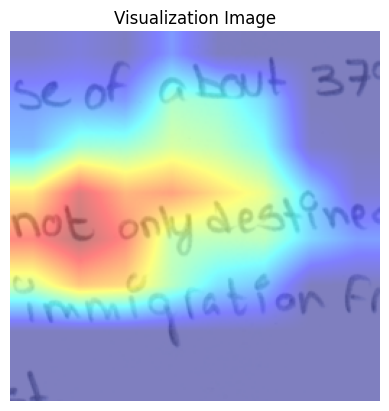

In [23]:
plt.imshow(visualization)
plt.axis('off')  # Turn off the axis
plt.title("Visualization Image")
plt.show()

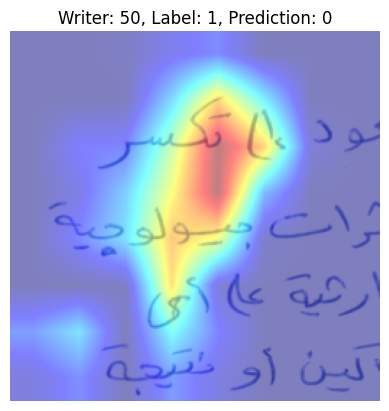

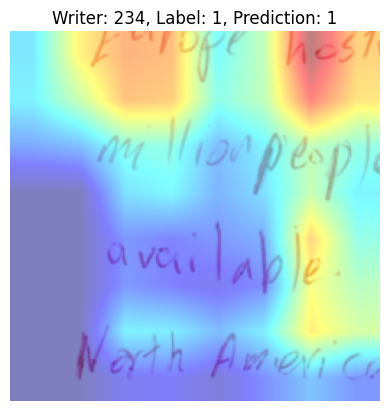

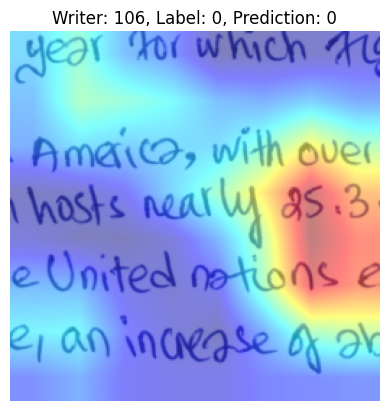

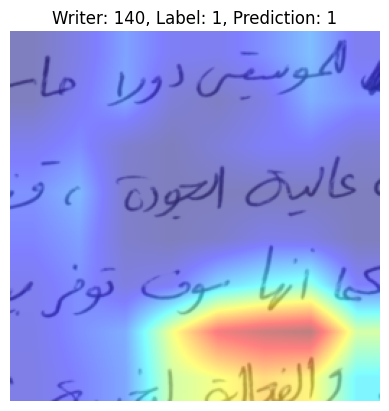

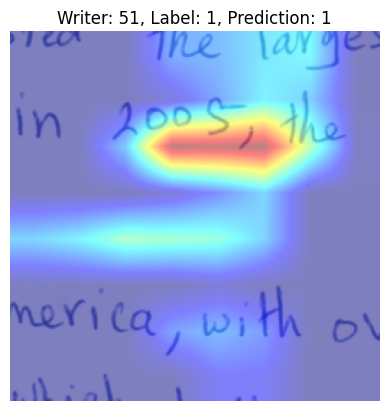

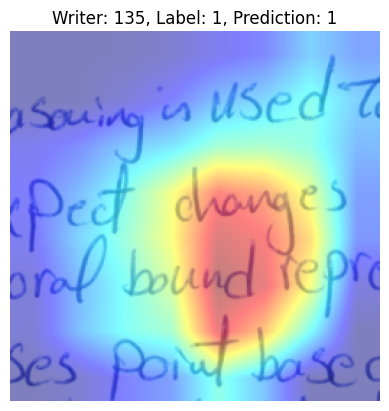

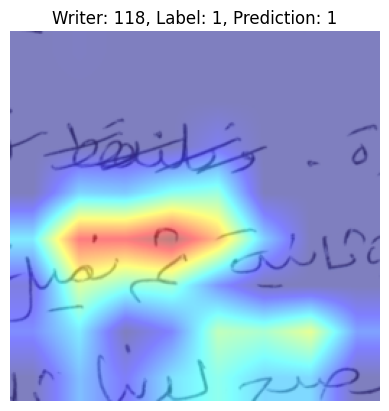

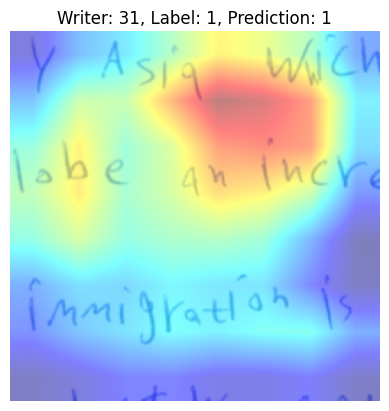

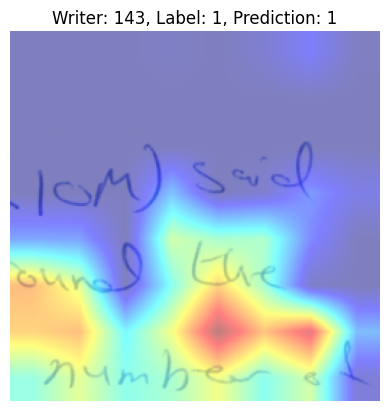

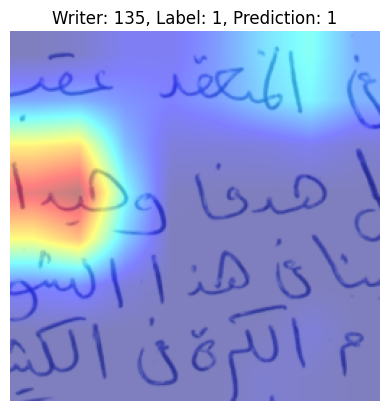

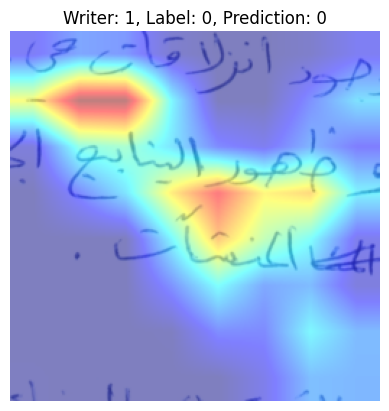

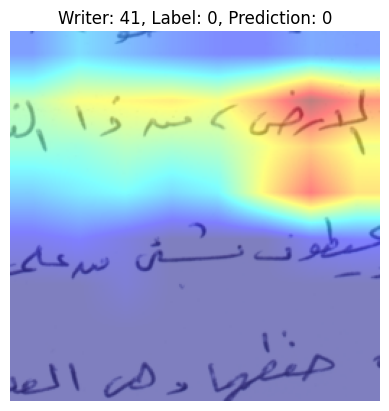

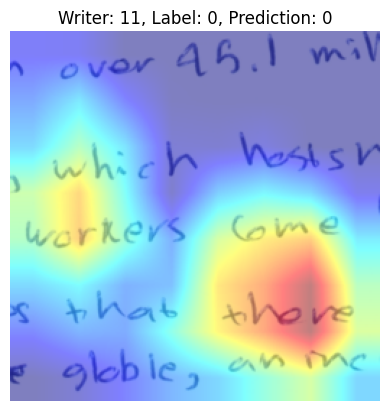

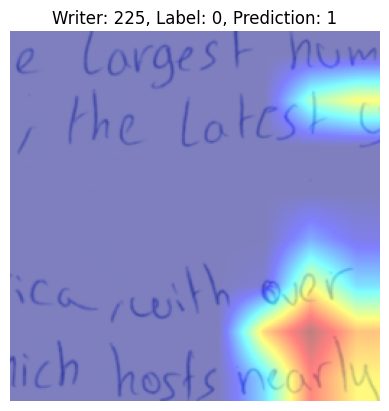

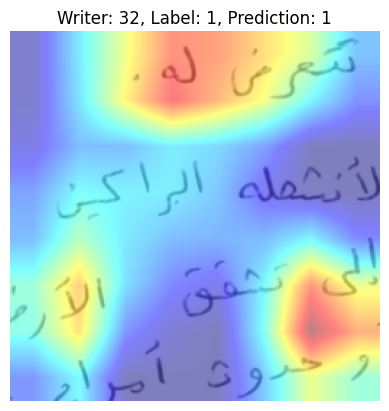

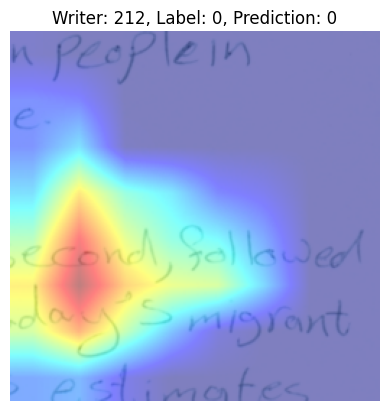

In [ ]:
# Get a batch of data from train_dataloader
batch_data = next(iter(train_dataloader))
images = batch_data['image']  # Extract images from the batch
writers = batch_data['writer']  # Extract writers from the batch
labels = batch_data['label']  # Extract labels from the batch

# Compute predictions for the batch
with torch.no_grad():
    outputs = sex_detection(images)
    predictions = outputs.argmax(dim=1)  # Get the predicted class for each image

# Prepare the input tensor for GradCAM
input_tensor = images  # The batch is already in the correct shape (batch_size, 3, H, W)

# Specify the target layers and targets
target_layers = [sex_detection.layer4[-1]]  # Usually the last conv layer
targets = [ClassifierOutputTarget(label.item()) for label in labels]  # Create targets for each image in the batch

# Construct the CAM object and apply it to the batch
with GradCAM(model=sex_detection, target_layers=target_layers) as cam:
    # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
    grayscale_cams = cam(input_tensor=input_tensor, targets=targets)
    
    # Visualize each image in the batch
    visualizations = []
    for i in range(len(images)):
        rgb_image = torch.clamp(images[i].permute(1, 2, 0), 0, 1).numpy().astype(np.float32)
        grayscale_cam = grayscale_cams[i]
        visualization = show_cam_on_image(rgb_image, grayscale_cam, use_rgb=True)
        visualizations.append(visualization)

# Display the visualizations
for i, visualization in enumerate(visualizations):
    plt.imshow(visualization)
    plt.title(f"Writer: {writers[i]}, Label: {labels[i]}, Prediction: {predictions[i]}")
    plt.axis('off')
    plt.show()
#recall 1 is male